In [3]:
### run the script from the figures_code directory
import os
import sys
os.chdir('../')
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from functions import data_processing as dp
from functions import general_functions as gf
from functions import lib_table_operations as lto
from functions import params

In [5]:
all_tf_coop = params.ALL_TF_COOP

## (A-C) Code for generating the matrices was written in matlab

In [ ]:
# script named 'genome_binding.m'

In [6]:
#generate data frame of all double motif controls
control_df = pd.DataFrame()
redandent_controls_tfs = ['Msn2', 'Msn2', 'Stp1', 'Ste12', 'Tec1', 'Abf1']
proms = ['Usv1', 'Usv1', 'Bap3', 'Pop3', 'Pop3', 'Gpp1']
combs = [['0_1'],['3_4'],['5_6'],['1_2'],['2_3'], ['1_2']]
for cont_tf_i, cont_tf in enumerate(redandent_controls_tfs):
    curr_prom = proms[cont_tf_i]
    curr_comb = combs[cont_tf_i]
    curr_data = all_tf_coop.query("TF==@cont_tf & Gene==@curr_prom & Comb==@curr_comb")
    control_id = np.argmax(curr_data['Obs-Exp_mean'])
    relevant_row = curr_data.query("TF==@cont_tf").iloc[control_id,:].to_frame().T
    control_df = pd.concat([control_df, relevant_row])
    all_tf_coop.drop(relevant_row.index,inplace=True)

## (D) All tfs, all libraries cooperativity scores

/tmp/ipykernel_107678/295033453.py:46: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.stripplot(data=self_comb_df, x='TF', y='Obs-Exp_mean',hue='Comb_type',palette=['k', 'white'], s=15,jitter=False, ax=ax)
/tmp/ipykernel_107678/295033453.py:64: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)
/tmp/ipykernel_107678/295033453.py:89: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.stripplot(data=control_df, x='TF', y='Obs-Exp_mean',hue='Comb_type',palette=['k', 'white'], s=15,jitter=False, ax=ax)
/tmp/ipykernel_107678/295033453.py:90: UserWarning: The palette list has more values (15) than needed (6), which may not be intended.
  sns.st

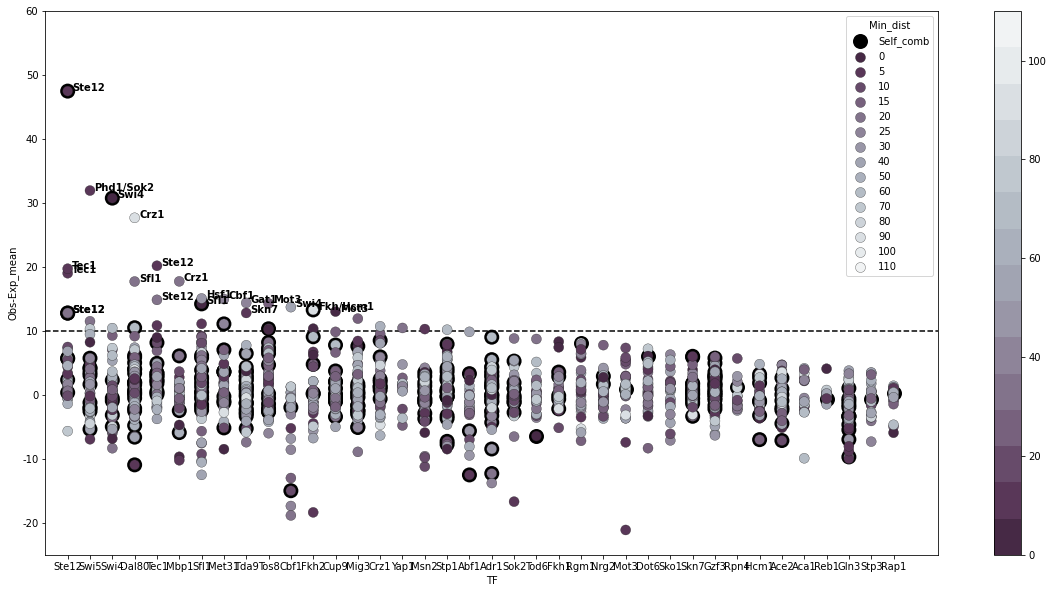

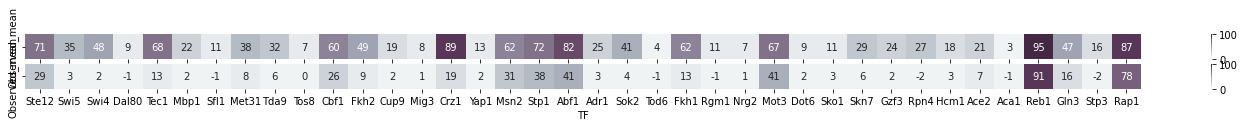

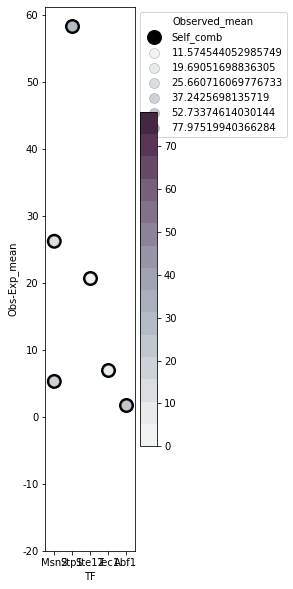

In [88]:
all_tf_coop = params.ALL_TF_COOP
all_tf_coop.drop(all_tf_coop.query("TF=='Usv1'").index, inplace=True)
all_tf_coop.reset_index(drop=True,inplace=True)
min_val = -25
max_val = 60
tresh = 10

min_vals = all_tf_coop['Min_dist'].values.copy()
bins = np.concatenate((np.arange(0,35, 5), np.arange(40,120, 10)))

for bin_i in range(len(bins)-1):
    low_bin = bins[bin_i]
    high_bin = bins[bin_i+1]
    bin_row_i = np.intersect1d(np.where(low_bin<min_vals)[0], np.where(min_vals<high_bin)[0])
    min_vals[bin_row_i] = high_bin
all_tf_coop['Min_dist'] = min_vals


all_tf_coop['Min_dist'] = all_tf_coop['Min_dist'].astype(int)
ordered_tfs = list(all_tf_coop.groupby(['TF'])['Obs-Exp_mean'].max().sort_values(ascending=False).index)
all_tf_coop_ordered = all_tf_coop.set_index('TF').loc[ordered_tfs]
all_tf_coop_ordered.reset_index(inplace=True)

color_palette = sns.color_palette("BuPu_r", len(bins), desat=.3)
norm = plt.Normalize(all_tf_coop_ordered['Min_dist'].min(), all_tf_coop_ordered['Min_dist'].max())
sm = plt.cm.ScalarMappable(cmap=matplotlib.colors.ListedColormap(sns.color_palette(color_palette).as_hex()), norm=norm)
sm.set_array([])

self_comb_df = all_tf_coop_ordered.query("Comb_type=='Self_comb'")
self_tfs = self_comb_df['TF'].unique()
all_tfs = all_tf_coop_ordered['TF'].unique()
non_self_tfs = np.setdiff1d(all_tfs, self_tfs)

empty_col_num =  len(self_comb_df.columns)-1
for curr_tf in non_self_tfs:
    curr_row = [np.nan]*empty_col_num
    curr_row = [curr_tf] +  curr_row
    curr_row_df = pd.DataFrame(curr_row).T
    curr_row_df.columns = self_comb_df.columns
    self_comb_df = pd.concat([self_comb_df ,curr_row_df])

self_comb_df = self_comb_df.set_index('TF').loc[ordered_tfs]
self_comb_df.reset_index(inplace=True)

fig,ax = plt.subplots(1,1,figsize=(20,10))
sns.stripplot(data=self_comb_df, x='TF', y='Obs-Exp_mean',hue='Comb_type',palette=['k', 'white'], s=15,jitter=False, ax=ax)
sns.stripplot(data=all_tf_coop_ordered, x='TF', y='Obs-Exp_mean',hue='Min_dist',
              palette=color_palette,linewidth=0.3, s=10,jitter=False, ax=ax)
ax.axline((0,10), slope=0, color='k', linestyle='--')
ax.set_xlim(-1,39)
ax.set_ylim(min_val, max_val)
ax.set_yticks(np.arange(round(min_val, -1),round(max_val, +1)+10,10))
ax.set_yticklabels(np.arange(round(min_val, -1),round(max_val, +1)+10,10).astype(str))

for line in range(0,all_tf_coop_ordered.shape[0]):
    curr_line = all_tf_coop.iloc[line, :]
    tf_i = np.where(all_tf_coop_ordered['TF'].unique() == curr_line['TF'])[0]
    curr_val = curr_line['Obs-Exp_mean']
    split_tfs = curr_line['Comb_tfs'].split('_')
    split_tfs.pop([i for i, curr_tfs in enumerate(split_tfs) if curr_line['TF'][0:3] in curr_tfs][0])
    if curr_val> 12:
        plt.text(tf_i+0.2,curr_val, split_tfs[0], horizontalalignment='left', size='medium', color='black', weight='semibold')
        
ax.figure.colorbar(sm)

max_obs = all_tf_coop_ordered.groupby('TF')['Observed_mean'].max().loc[ordered_tfs].to_frame().reset_index()
max_obs.set_index('TF', inplace=True)
max_obs = max_obs.T
max_obs.loc['Observed_mean'] = max_obs.loc['Observed_mean'].round(decimals=0).astype('int32')

med_obs = all_tf_coop_ordered.groupby('TF')['Observed_mean'].median().loc[ordered_tfs].to_frame().reset_index()
med_obs.set_index('TF', inplace=True)
med_obs = med_obs.T
med_obs.loc['Observed_mean'] = med_obs.loc['Observed_mean'].round(decimals=0).astype('int32')


color_palette = sns.color_palette("BuPu", len(bins), desat=.3)
fig,axes = plt.subplots(2,1,figsize=(25,1))
sns.heatmap(data=max_obs, cmap=color_palette, ax=axes[0], vmin=0, vmax=100, annot=True)
sns.heatmap(data=med_obs, cmap=color_palette, ax=axes[1], vmin=0, vmax=100, annot=True)

color_palette = sns.color_palette("BuPu", len(bins), desat=.3)

norm = plt.Normalize(0, control_df['Observed_mean'].max())
sm = plt.cm.ScalarMappable(cmap=matplotlib.colors.ListedColormap(sns.color_palette(color_palette).as_hex()), norm=norm)
sm.set_array([])

fig,ax = plt.subplots(1,1,figsize=(2,10))
sns.stripplot(data=control_df, x='TF', y='Obs-Exp_mean',hue='Comb_type',palette=['k', 'white'], s=15,jitter=False, ax=ax)
sns.stripplot(data=control_df, x='TF', y='Obs-Exp_mean',hue='Observed_mean',
              palette=color_palette, linewidth=0.3, s=10, jitter=False,ax=ax)

ax.set_yticks(np.arange(round(min_val, -1),round(max_val, +1)+10,10))
ax.set_yticklabels(np.arange(round(min_val, -1),round(max_val, +1)+10,10).astype(str))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.figure.colorbar(sm)       

## (E) Motif distances by interaction

/tmp/ipykernel_107678/960015140.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_tf_coop['Interaction'] = interaction_vec


<AxesSubplot: xlabel='Interaction', ylabel='Min_dist'>

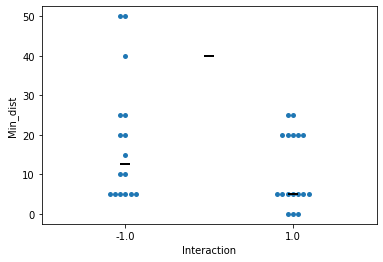

In [110]:
all_tf_coop = params.ALL_TF_COOP

obs_tresh = 10
inter_tresh = 10

coop_ids = np.where((all_tf_coop['Observed_mean']>obs_tresh) & (all_tf_coop['Obs-Exp_mean']>inter_tresh))[0]
inhibition_ids = np.where((all_tf_coop['Obs-Exp_mean']<-inter_tresh))[0]
obs_no_interaction_ids = np.where((all_tf_coop['Obs-Exp_mean']>-inter_tresh) & (all_tf_coop['Obs-Exp_mean']<inter_tresh) & (all_tf_coop['Observed_mean']>obs_tresh))[0]

ids = np.concatenate((coop_ids, inhibition_ids, obs_no_interaction_ids))
all_tf_coop = all_tf_coop.iloc[ids,:]

interaction_vec = np.zeros((len(all_tf_coop),1))
interaction_vec[all_tf_coop['Obs-Exp_mean']>tresh] = 1
interaction_vec[all_tf_coop['Obs-Exp_mean']<-tresh] = -1
all_tf_coop['Interaction'] = interaction_vec

all_tf_coop_inter = all_tf_coop.query("Interaction != 0")
med_inter = all_tf_coop[['Interaction','Min_dist']].groupby('Interaction').median()

fig,ax = plt.subplots(1,1)
sns.scatterplot(data=med_inter, x=[0, 0.5, 1], y='Min_dist', marker='_', s=100, linewidth=2, color='k', zorder=20)
ylim_max = all_tf_coop['Min_dist'].max()
ylim_min = all_tf_coop['Min_dist'].min()

sns.swarmplot(data=all_tf_coop_inter, x='Interaction', y='Min_dist')
